
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

# Import Packages and Data

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.inspection import plot_partial_dependence
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

df_raw = pd.read_csv('../data/msrp.csv')

# Wrangle Data

In [2]:
## USE ASSIGN23 AS FINAL REFERENCE
def wrangle(df):
    df = df.copy()
    
    ## Fix column names
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    ## Remove Outliers
    df = df[df['msrp'] <= 75000]
    
    ## Reduce high cardinality in 'make'
    df['make'] = [x if x in list(df['make'].value_counts().sort_values().tail(5).index) else 'Other' for x in df['make']]
    
    ## Reduce high cardinality in 'market_category' (maybe remove NaN's)
    df['luxury'] = [x if type(x)==float else 1 if 'Luxury' in x else 0 for x in df['market_category']]
    
    ## 'Model' is going to allow for leakage in a way
    df.drop(columns=['model', 'market_category'], inplace=True)
    
    return df

In [3]:
df = wrangle(df_raw)

# Split Data

In [4]:
target_reg = 'msrp'
target_class = 'make'
y_reg = df[target_reg]
X_reg = df.drop(columns=target_reg)
y_class = df[target_class]
X_class = df.drop(columns=target_class)

In [5]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
X_class_train, X_class_val, y_class_train, y_class_val = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Build Models


In [6]:
linreg = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LinearRegression()
)

linreg.fit(X_reg_train, y_reg_train);

In [7]:
rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=50,
                           max_depth=10,
                          random_state=42)
)

rf.fit(X_class_train, y_class_train);

# Check Metrics

In [9]:
y_pred = [y_reg_train.mean()]*len(y_reg_train)
print('Baseline MAE:', mean_absolute_error(y_reg_train, y_pred))
print('LinReg Training MAE:', mean_absolute_error(y_reg_train, linreg.predict(X_reg_train)))
print('LinReg Test MAE:', mean_absolute_error(y_reg_test, linreg.predict(X_reg_test)))

Baseline MAE: 12429.751641196048
LinReg Training MAE: 5541.068739006572
LinReg Test MAE: 5529.234746267845


In [10]:
print('RF Baseline Accuracy:', y_class_train.value_counts(normalize=True).max())
print('RF Training Accuracy:', rf.score(X_class_train, y_class_train))
print('RF Validation Accuracy:', rf.score(X_class_val, y_class_val))

RF Baseline Accuracy: 0.6208157203244602
RF Training Accuracy: 0.9449331657717354
RF Validation Accuracy: 0.9428962996802193


# Partial Dependence

ValueError: target must be specified for multi-class

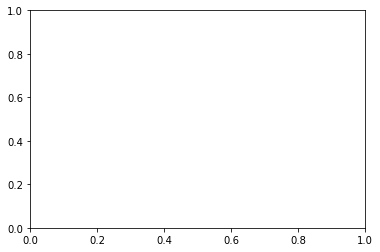

In [20]:
fig, ax = plt.subplots()

plot_partial_dependence(
    rf,
    X_class.columns,
    features=['make'],
    X=df,
    ax=ax
)

In [32]:
X_class_val.columns

Index(['year', 'engine_fuel_type', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'driven_wheels', 'number_of_doors', 'vehicle_size',
       'vehicle_style', 'highway_mpg', 'city_mpg', 'popularity', 'msrp',
       'luxury'],
      dtype='object')

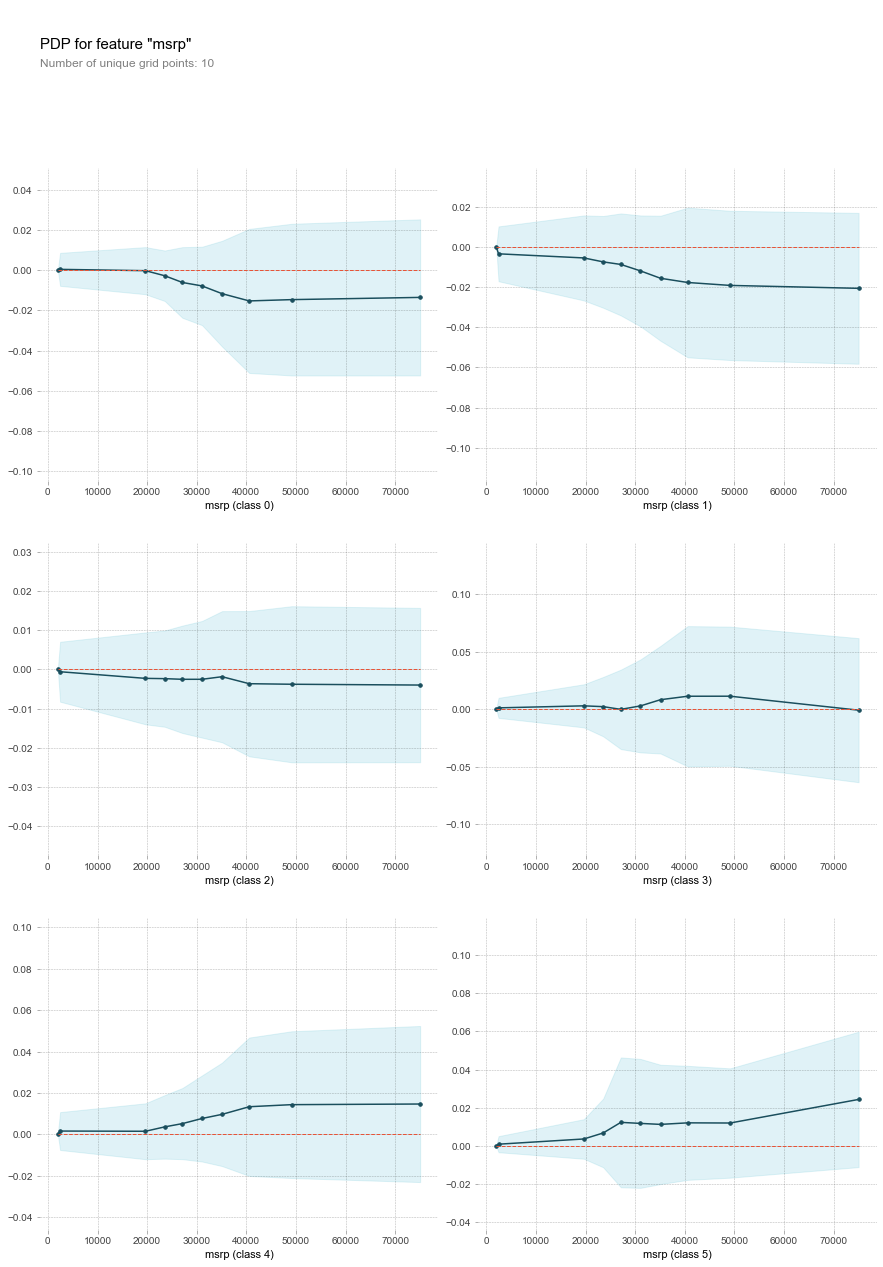

In [35]:
isolated = pdp_isolate(
    model=rf,
    dataset=X_class_val,
    model_features=X_class_val.columns,
    feature='msrp'
)

pdp_plot(isolated, feature_name='msrp');

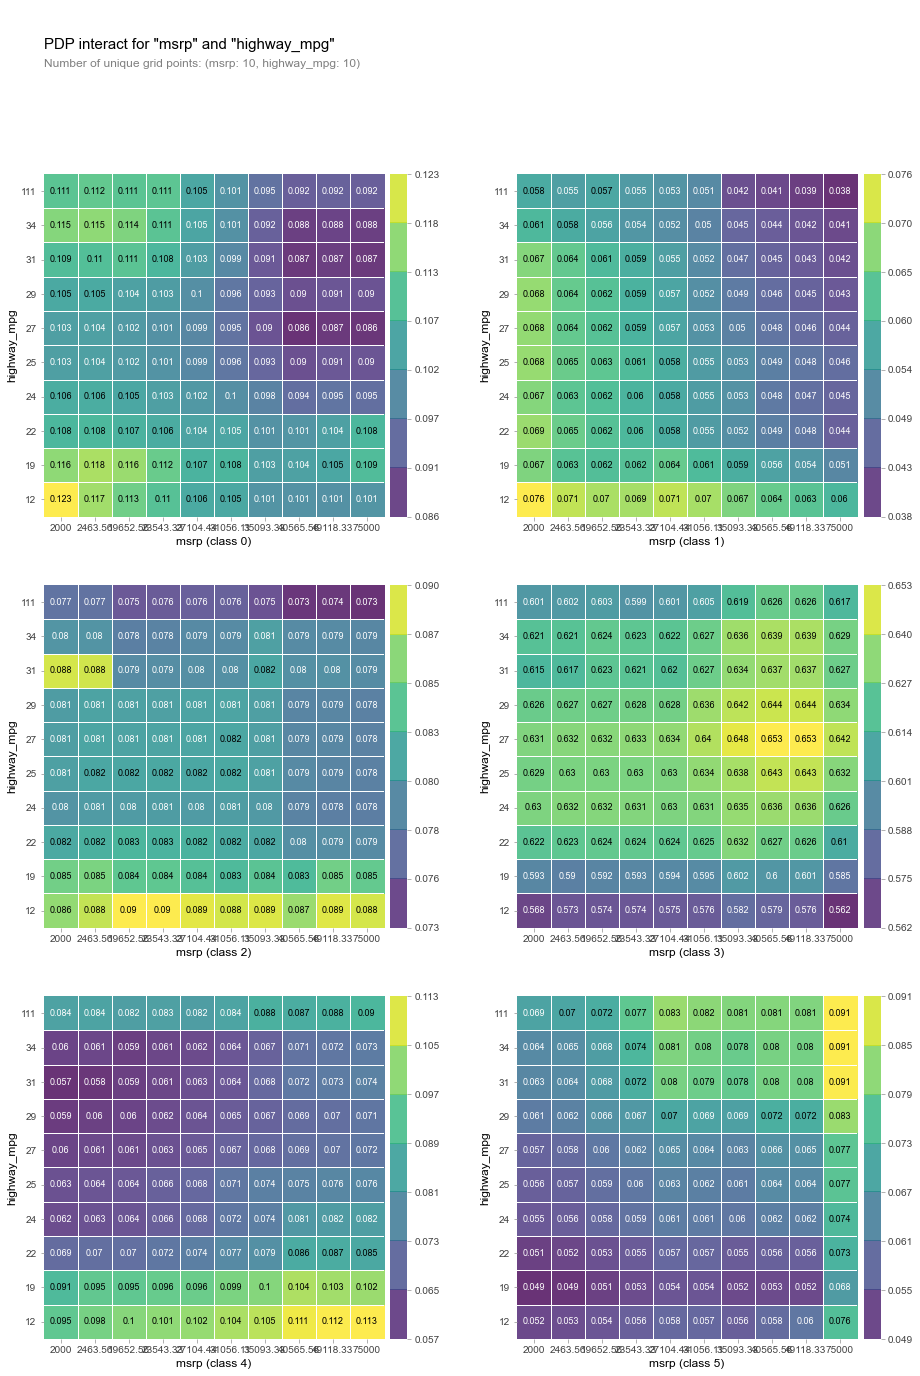

In [47]:
interact = pdp_interact(
    model=rf,
    dataset=X_class_val,
    model_features=X_class_val.columns,
    features=['msrp', 'highway_mpg']
)

pdp_interact_plot(interact, plot_type='grid', feature_names=['msrp', 'highway_mpg']);